# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [87]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

c:\users\пользователь\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
c:\users\пользователь\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel pac

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [5]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [37]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [40]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [41]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float64))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [68]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float64)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int64)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float64)
target_index = np.random.randint(0, 2, size=(batch_size, 1)).astype(np.int64).reshape(1, -1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [71]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float64)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float64)
target_index = np.ones(batch_size, dtype=np.int64)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [73]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [77]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 1055.086909
Epoch 1, loss: 870.183439
Epoch 2, loss: 1037.316240
Epoch 3, loss: 953.088692
Epoch 4, loss: 776.617279
Epoch 5, loss: 959.029192
Epoch 6, loss: 977.682835
Epoch 7, loss: 1060.178294
Epoch 8, loss: 848.900040
Epoch 9, loss: 824.920023


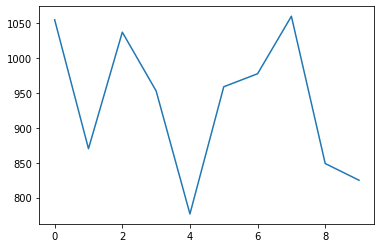

In [78]:
# let's look at the loss history!
plt.plot(loss_history)

In [81]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.169
Epoch 0, loss: 820.541176
Epoch 1, loss: 919.686933
Epoch 2, loss: 820.996239
Epoch 3, loss: 920.991001
Epoch 4, loss: 864.140768
Epoch 5, loss: 1031.126230
Epoch 6, loss: 1000.033425
Epoch 7, loss: 895.569659
Epoch 8, loss: 978.593129
Epoch 9, loss: 859.282500
Epoch 10, loss: 1062.394772
Epoch 11, loss: 900.900964
Epoch 12, loss: 856.455941
Epoch 13, loss: 932.153493
Epoch 14, loss: 888.408562
Epoch 15, loss: 776.167241
Epoch 16, loss: 1012.114524
Epoch 17, loss: 872.038077
Epoch 18, loss: 1125.417483
Epoch 19, loss: 747.960765
Epoch 20, loss: 955.321735
Epoch 21, loss: 915.970179
Epoch 22, loss: 846.705540
Epoch 23, loss: 1022.794247
Epoch 24, loss: 899.288083
Epoch 25, loss: 925.442639
Epoch 26, loss: 720.157794
Epoch 27, loss: 887.710059
Epoch 28, loss: 823.255647
Epoch 29, loss: 870.011700
Epoch 30, loss: 920.217649
Epoch 31, loss: 859.589870
Epoch 32, loss: 847.248802
Epoch 33, loss: 903.310686
Epoch 34, loss: 804.341868
Epoch 35, loss: 1009.692522
Epoch 36, loss

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [90]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = 0

#df = pd.DataFrame(columns = learning_rates, index = reg_strengths)

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially
for learning_rate in learning_rates:
    for reg in reg_strengths:
        clf = linear_classifer.LinearSoftmaxClassifier()
        clf.fit(train_X, train_y, batch_size = batch_size, learning_rate = learning_rate, reg = reg, epochs = num_epochs)
        preds = clf.predict(test_X)
        accuracy = multiclass_accuracy(preds, test_y)
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            best_classifier = clf


        

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 864.123209
Epoch 1, loss: 1031.151524
Epoch 2, loss: 854.462479
Epoch 3, loss: 745.929690
Epoch 4, loss: 792.352896
Epoch 5, loss: 989.778082
Epoch 6, loss: 730.628475
Epoch 7, loss: 956.406596
Epoch 8, loss: 705.386016
Epoch 9, loss: 745.762882
Epoch 10, loss: 691.949937
Epoch 11, loss: 804.413547
Epoch 12, loss: 759.395383
Epoch 13, loss: 851.785196
Epoch 14, loss: 737.258366
Epoch 15, loss: 742.892914
Epoch 16, loss: 797.439111
Epoch 17, loss: 794.944468
Epoch 18, loss: 794.787950
Epoch 19, loss: 806.885664
Epoch 20, loss: 854.534535
Epoch 21, loss: 750.034602
Epoch 22, loss: 729.663051
Epoch 23, loss: 797.610118
Epoch 24, loss: 804.528812
Epoch 25, loss: 874.416972
Epoch 26, loss: 852.958736
Epoch 27, loss: 805.065720
Epoch 28, loss: 702.671076
Epoch 29, loss: 744.252845
Epoch 30, loss: 780.984563
Epoch 31, loss: 1188.784439
Epoch 32, loss: 860.750681
Epoch 33, loss: 852.897230
Epoch 34, loss: 721.506489
Epoch 35, loss: 728.160632
Epoch 36, loss: 909.473417
Epoch 37,

Epoch 101, loss: 797.392671
Epoch 102, loss: 729.120402
Epoch 103, loss: 873.149328
Epoch 104, loss: 782.118748
Epoch 105, loss: 704.311021
Epoch 106, loss: 722.018203
Epoch 107, loss: 754.805667
Epoch 108, loss: 808.984852
Epoch 109, loss: 670.492247
Epoch 110, loss: 759.935147
Epoch 111, loss: 707.699191
Epoch 112, loss: 821.625338
Epoch 113, loss: 738.105336
Epoch 114, loss: 802.141422
Epoch 115, loss: 799.517005
Epoch 116, loss: 769.604635
Epoch 117, loss: 689.911074
Epoch 118, loss: 830.693655
Epoch 119, loss: 838.373812
Epoch 120, loss: 687.418299
Epoch 121, loss: 673.661509
Epoch 122, loss: 869.764102
Epoch 123, loss: 818.806466
Epoch 124, loss: 735.238293
Epoch 125, loss: 748.532126
Epoch 126, loss: 839.923389
Epoch 127, loss: 821.274720
Epoch 128, loss: 789.510489
Epoch 129, loss: 771.290181
Epoch 130, loss: 715.646355
Epoch 131, loss: 678.720437
Epoch 132, loss: 666.279049
Epoch 133, loss: 911.214210
Epoch 134, loss: 669.511245
Epoch 135, loss: 947.116046
Epoch 136, loss: 714

Epoch 198, loss: 838.788505
Epoch 199, loss: 763.419467
Epoch 0, loss: 684.258943
Epoch 1, loss: 685.453136
Epoch 2, loss: 677.239645
Epoch 3, loss: 670.768140
Epoch 4, loss: 664.030370
Epoch 5, loss: 664.377179
Epoch 6, loss: 658.945078
Epoch 7, loss: 659.257088
Epoch 8, loss: 652.653113
Epoch 9, loss: 652.714485
Epoch 10, loss: 656.368596
Epoch 11, loss: 655.140881
Epoch 12, loss: 647.264105
Epoch 13, loss: 657.335447
Epoch 14, loss: 655.196613
Epoch 15, loss: 650.154499
Epoch 16, loss: 656.914953
Epoch 17, loss: 651.399671
Epoch 18, loss: 660.137787
Epoch 19, loss: 651.725606
Epoch 20, loss: 646.631348
Epoch 21, loss: 653.394793
Epoch 22, loss: 633.171876
Epoch 23, loss: 649.010230
Epoch 24, loss: 637.136575
Epoch 25, loss: 653.002001
Epoch 26, loss: 657.008853
Epoch 27, loss: 644.999751
Epoch 28, loss: 644.625638
Epoch 29, loss: 642.201534
Epoch 30, loss: 637.633875
Epoch 31, loss: 630.848811
Epoch 32, loss: 630.464147
Epoch 33, loss: 629.683814
Epoch 34, loss: 629.894914
Epoch 35,

Epoch 99, loss: 628.736098
Epoch 100, loss: 629.506393
Epoch 101, loss: 622.735173
Epoch 102, loss: 610.257245
Epoch 103, loss: 642.660070
Epoch 104, loss: 623.566180
Epoch 105, loss: 633.321102
Epoch 106, loss: 626.464711
Epoch 107, loss: 643.919283
Epoch 108, loss: 625.649524
Epoch 109, loss: 627.502222
Epoch 110, loss: 624.372869
Epoch 111, loss: 628.115655
Epoch 112, loss: 632.127192
Epoch 113, loss: 606.665138
Epoch 114, loss: 609.529419
Epoch 115, loss: 619.754985
Epoch 116, loss: 618.563960
Epoch 117, loss: 620.618675
Epoch 118, loss: 634.456290
Epoch 119, loss: 629.118884
Epoch 120, loss: 606.964139
Epoch 121, loss: 622.750454
Epoch 122, loss: 624.204039
Epoch 123, loss: 622.101852
Epoch 124, loss: 613.187386
Epoch 125, loss: 629.433282
Epoch 126, loss: 635.232373
Epoch 127, loss: 624.450387
Epoch 128, loss: 618.554148
Epoch 129, loss: 627.308202
Epoch 130, loss: 640.859661
Epoch 131, loss: 623.855144
Epoch 132, loss: 614.046460
Epoch 133, loss: 617.703388
Epoch 134, loss: 620.

Epoch 196, loss: 609.855409
Epoch 197, loss: 619.070410
Epoch 198, loss: 597.712600
Epoch 199, loss: 626.100706
Epoch 0, loss: 690.096380
Epoch 1, loss: 689.087233
Epoch 2, loss: 687.777467
Epoch 3, loss: 687.649768
Epoch 4, loss: 686.763387
Epoch 5, loss: 686.305153
Epoch 6, loss: 683.677895
Epoch 7, loss: 684.525307
Epoch 8, loss: 686.513056
Epoch 9, loss: 684.589745
Epoch 10, loss: 685.388493
Epoch 11, loss: 680.437708
Epoch 12, loss: 681.510793
Epoch 13, loss: 681.645197
Epoch 14, loss: 680.416105
Epoch 15, loss: 682.275792
Epoch 16, loss: 681.610271
Epoch 17, loss: 679.206765
Epoch 18, loss: 676.988646
Epoch 19, loss: 677.160729
Epoch 20, loss: 676.646496
Epoch 21, loss: 678.916675
Epoch 22, loss: 678.345553
Epoch 23, loss: 675.475893
Epoch 24, loss: 675.996525
Epoch 25, loss: 675.168985
Epoch 26, loss: 675.502784
Epoch 27, loss: 675.038624
Epoch 28, loss: 680.130328
Epoch 29, loss: 672.598280
Epoch 30, loss: 671.626142
Epoch 31, loss: 672.558724
Epoch 32, loss: 672.098640
Epoch 3

Epoch 97, loss: 665.944109
Epoch 98, loss: 652.178809
Epoch 99, loss: 659.611168
Epoch 100, loss: 663.517581
Epoch 101, loss: 650.800526
Epoch 102, loss: 654.397475
Epoch 103, loss: 659.094103
Epoch 104, loss: 648.867123
Epoch 105, loss: 650.789006
Epoch 106, loss: 637.826687
Epoch 107, loss: 651.214504
Epoch 108, loss: 653.246270
Epoch 109, loss: 652.523971
Epoch 110, loss: 650.379870
Epoch 111, loss: 651.294788
Epoch 112, loss: 655.529652
Epoch 113, loss: 649.136705
Epoch 114, loss: 658.752332
Epoch 115, loss: 649.346853
Epoch 116, loss: 652.028896
Epoch 117, loss: 659.556837
Epoch 118, loss: 654.715147
Epoch 119, loss: 659.184322
Epoch 120, loss: 652.528271
Epoch 121, loss: 662.314652
Epoch 122, loss: 644.727826
Epoch 123, loss: 653.617799
Epoch 124, loss: 651.186393
Epoch 125, loss: 639.145557
Epoch 126, loss: 644.738107
Epoch 127, loss: 664.787426
Epoch 128, loss: 652.501591
Epoch 129, loss: 640.377082
Epoch 130, loss: 644.026562
Epoch 131, loss: 647.492423
Epoch 132, loss: 664.19

Epoch 194, loss: 662.837467
Epoch 195, loss: 651.572468
Epoch 196, loss: 638.480666
Epoch 197, loss: 652.064249
Epoch 198, loss: 654.662086
Epoch 199, loss: 642.813676
best validation accuracy achieved: 0.216000


# Какой же точности мы добились на тестовых данных?

In [91]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.216000
